In [2]:
import pandas as pd 
import numpy as np
import pickle
import datetime
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import matplotlib.pyplot as plt

from xbos import get_client
from xbos.services import mdal
from xbos.services.hod import HodClient
from xbos.devices.thermostat import Thermostat

In [2]:
thermostat_query = """SELECT ?zone ?uri FROM ciee WHERE { 
          ?tstat rdf:type brick:Thermostat .
          ?tstat bf:hasLocation/bf:isPartOf ?location_zone .
          ?location_zone rdf:type brick:HVAC_Zone .
          ?tstat bf:controls ?RTU .
          ?RTU rdf:type brick:RTU . 
          ?RTU bf:feeds ?zone. 
          ?zone rdf:type brick:HVAC_Zone . 
          ?tstat bf:uri ?uri.
        };"""

In [3]:
client = get_client()
hod_client = HodClient("xbos/hod", client)

Saw [xbos/hod] HodDB 2 seconds 746.05 ms ago


In [4]:
thermostat_query_data = hod_client.do_query(thermostat_query)["Rows"]

In [7]:
tstats = {tstat["?zone"]: Thermostat(client, tstat["?uri"]) for tstat in thermostat_query_data}

Got Thermostat at ciee/devices/venstar/s.venstar/ConferenceRoom/i.xbos.thermostat last alive 2018-05-24T04:32:02.781421843Z
Got Thermostat at ciee/devices/venstar/s.venstar/Clarity/i.xbos.thermostat last alive 2018-05-24T04:32:02.795648348Z
Got Thermostat at ciee/devices/pelican/s.pelican/SouthEastCorner/i.xbos.thermostat last alive 2018-05-24T04:32:02.724361981Z
Got Thermostat at ciee/devices/venstar/s.venstar/OpenSpace/i.xbos.thermostat last alive 2018-05-24T04:32:02.79680965Z


In [8]:

COOLING_ACTION = lambda tstat: {"heating_setpoint": 40, "cooling_setpoint": 45, "override": True, "mode": 3}
HEATING_ACTION = lambda tstat: {"heating_setpoint": 90, "cooling_setpoint": 95, "override": True, "mode": 3}
NO_ACTION = lambda tstat: {"heating_setpoint": tstat.temperature - 5, "cooling_setpoint": tstat.temperature + 5, "override": True, "mode": 3}

def gatherZoneData(tstat):
    data = {  "heating_setpoint": tstat.heating_setpoint,
              "cooling_setpoint": tstat.cooling_setpoint,
              "state": tstat.state,
              "temperature": tstat.temperature}
    return data

def loopAction(tstats, action_messages, interval, dt):
    """
    :param tstats: {zone: tstat object}
    :param action_messages: {zone: action dictionary}
    :param interval: how long to execute action in minutes
    :param dt: how often to record data and rewrite message in minutes
    returns: {zone: pd.df columns:["heating_setpoint",
              "cooling_setpoint",
              "state",
              "temperature", "dt"] index=time right after all actions were written to thermostats (freq=dt)}"""
    start_time = time.time()
    recorded_data = defaultdict(list)
    
    while time.time() - start_time < 60*interval:
        # potential improvement is to make the times more accurate
        run_time = time.time()
        for zone, action in action_messages.items():
            tstats[zone].write(action(tstats[zone]))
        
        # using dt as we assume it will be, (i.e. runtime less than dt). We can infer later if it differs. 
        time_data = {"time": datetime.datetime.utcnow(), "dt": dt}
        for zone, tstat in tstats.items():
            row = gatherZoneData(tstat)
            row.update(time_data)
            recorded_data[zone].append(row)
        
        # usually iteration of loop takes less than 0.1 seconds. 
        if dt*60 - (time.time() - run_time) < 0:
            print("Warning: An iteration of the loop took too long. At utc_time: ", time_data["time"])
        time.sleep(max(dt*60 - (time.time() - run_time), 0))
        
    dataframe_data = {}
    for zone, data in recorded_data.items():
        data = pd.DataFrame(data).set_index('time')
        dataframe_data[zone] = data
    return dataframe_data
        
    
def control(tstats, interval=30, dt=1):
    zone_order = tstats.keys() # establishes order in which to perform actions.
    
    action_order = {"0":NO_ACTION, "1": HEATING_ACTION, "2": COOLING_ACTION} # in dictionary so we can shuffle easier if wanted. 
    
    # control one zone. All others do nothing. 
    final_data = {}
    for action_zone in zone_order:
        zone_data = defaultdict(list)
        for i in range(3):
            # re setting since I want to store data all the time. Just to make sure we aren't loosing anything. 
            zone_data = defaultdict(list)
            
            action = action_order[str(i)]
        
            # set action for each zone
            action_messages = {}
            for zone in zone_order:
                if zone == action_zone:
                    action_messages[zone] = action
                else:
                    action_messages[zone] = action_order[str(0)] # no action
            action_data = loopAction(tstats, action_messages, interval, dt)
            for zone, df in action_data.items():
                if zone == action_zone:
                    df["action"] = np.ones(df.shape[0]) * i
                else:
                    df["action"] = np.ones(df.shape[0]) * 0
                zone_data[zone].append(df)
            
            print("Done with action: ", i)
            with open("./Freezing_CIEE/"+ str(i) + ";"+  action_zone + ";" + datetime.datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S'), "wb") as f:
                pickle.dump({"zone": action_zone, "action": i, "data": zone_data}, f)
        print("done with zone", action_zone)
#         for zone, arr in zone_data.items():
#             final_data[zone] = pd.DataFrame(arr)
#         print(final_data)


# control(tstats, interval = 30, dt = 30/60.) 

In [34]:
zone_tstat = tstats["HVAC_Zone_Southzone"]
zone_tstat.write(NO_ACTION(zone_tstat))
i = 0


In [37]:
l = lambda : (not (zone_tstat.heating_setpoint < zone_tstat.temperature < zone_tstat.cooling_setpoint)) or (i ==0)
print(zone_tstat.heating_setpoint)
print(zone_tstat.cooling_setpoint)
print(zone_tstat.temperature)
print(l())

69.0
79.0
74.0
True


HVAC_Zone_Eastzone


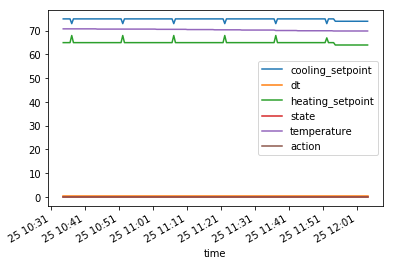

HVAC_Zone_Southzone


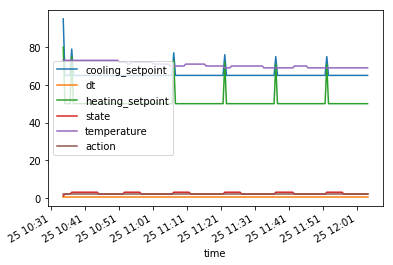

HVAC_Zone_Centralzone


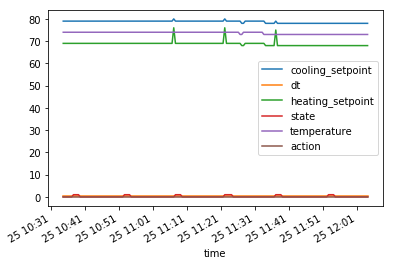

HVAC_Zone_Northzone


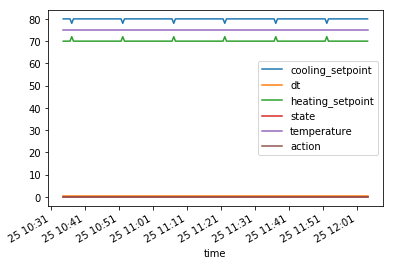

In [5]:
file_name = "2;HVAC_Zone_Southzone;2018-05-25_12-04-43"
with open("./Freezing_CIEE/" + file_name, "r") as f:
    thermal_data = pickle.load(f)


for zone, data in thermal_data["data"].items():
    print(zone)
    data[0].plot()
    plt.show()
    

In [44]:
a = {"asf": 2}
datetime.datetime.utcnow()

datetime.datetime(2018, 5, 24, 4, 51, 51, 222680)